# Figures 6H, S6C and S6D

## 01. settings

In [1]:
# python 3.8
import os
import re

import cellrank as cr
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import scvelo as scv
from matplotlib import rcParams

In [2]:
sc.set_figure_params(dpi=100, color_map="viridis", fontsize=6)
sc.settings.figdir = ""
sc.settings.verbosity = 2
sc.settings.n_jobs = 10
sc.logging.print_versions()

scv.settings.figdir = ""
scv.settings.plot_prefix = ""

dir_for_data = "data/trajectory_analysis"
dir_for_scVelo_input = "data/trajectory_analysis/memory_tumor_for_scVelo.h5ad"
dir_for_scVelo_input_loom = "data/trajectory_analysis/merged_loom.h5ad"
dir_for_annotation_color = "data/trajectory_analysis/annotation_color.txt"
dir_for_black_list_genes = "data/black_list_genes.tsv"
dir_for_result = "figures"

if not os.path.exists(dir_for_result):
    os.makedirs(dir_for_result)
os.chdir(dir_for_result)


-----
anndata     0.9.2
scanpy      1.8.2
sinfo       0.3.1
-----
PIL                         9.4.0
anndata                     0.9.2
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cellrank                    1.5.1
cffi                        1.16.0
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
docrep                      0.3.2
entrypoints                 0.4
executing                   0.10.0
h5py                        3.8.0
hypergeom_ufunc             NA
igraph                      0.10.2
ipykernel                   6.15.1
jedi                        0.18.1
joblib                      1.3.0
kiwisolver                  1.4.2
leidenalg                   0.9.1
llvmlite                    0.38.0
louvain                     0.8.0
matplotlib                

## 02. load data

In [3]:
adata = scv.read(
    dir_for_scVelo_input,
    cache=True,
)
adata.obs["annotation"] = adata.obs["annotation"].astype("category")

In [4]:
# color
color = pd.read_csv(
    dir_for_annotation_color,
    sep="\t",
    header=None,
    index_col=0,
)
color_used = list(color.loc[adata.obs["annotation"].cat.categories, 1])
adata.uns["annotation_colors"] = color_used

### select only 3 clusters

In [5]:
## subset
flag = [
    i in ["c04_MemB_TXNIP", "c07_MemB_ISG15", "c08_MemB_FCRL4"]
    for i in adata.obs.loc[:, "annotation"]
]
adata = adata[flag, ]

### remove blacklist genes

In [6]:
ignoreGenes = pd.read_csv(dir_for_black_list_genes, sep="\t")
flag = [not i in list(ignoreGenes["geneSymbol"]) for i in list(adata.var.index)]
adata = adata[:, flag]
# remove ribosome genes
flag = [not bool(re.match("^RP[LS]", i)) for i in adata.var_names]
adata = adata[:, flag]
adata

View of AnnData object with n_obs × n_vars = 3184 × 920
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cellID', 'sampleID', 'patientID', 'datasetID', 'identifier', 'cancer', 'tissue', 'tissue_short', 'platform', 'age', 'sex', 'pTNM', 'FACS', 'treatment_status', 'ICB_treatment', 'treatment', 'treatment_response', 'cellType_in_paper', 'PatientID', 'SampleID', 'CellID', 'percent.mito', 'majortype_annotated', 'majortype_combined', 'Cancer', 'DatasetID_new', 'data_type', 'percent.mt', 'percent.hsp', 'percent.ig', 'S.Score', 'G2M.Score', 'Phase', 'HSP.Score', 'majortype_paper', 'IGHA1', 'IGHA2', 'IGHD', 'IGHM', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHE', 'DatasetID_V3', 'RNA_snn_res.0.1', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'RNA_snn_res.1', 'RNA_snn_res.2', 'seurat_clusters', 'CellID_old', 'doublet', 'major_annotation', 'major_annotation2', 'annotation', 'major_annotation3', 'annotation_new', 'loom_cellID'
    var: 'features'
    uns: 'annotation_colors'
    obsm:

## 03. run diffusion map

In [7]:
sc.pp.neighbors(adata, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:04)


In [8]:
sc.tl.diffmap(adata, n_comps=10)

computing Diffusion Maps using n_comps=10(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9838765  0.9733206  0.95351535 0.9487467  0.9375559
     0.92459893 0.9146914  0.9041639  0.89795035]
    finished (0:00:00)


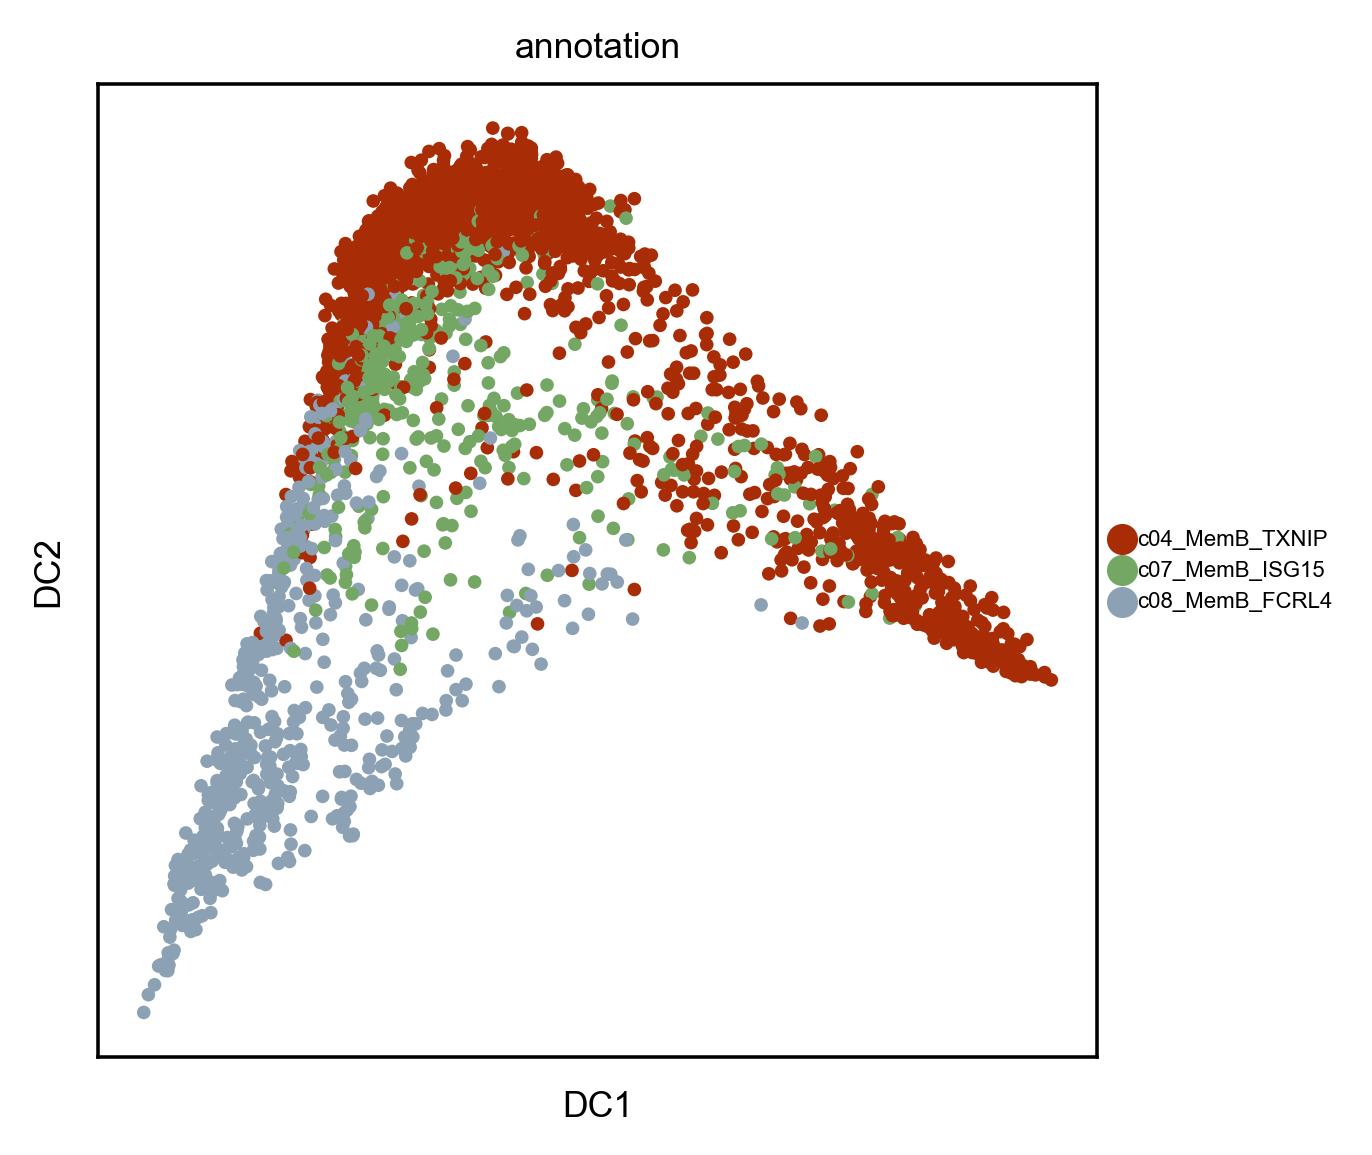

In [9]:
sc.set_figure_params(dpi=160, color_map="viridis", fontsize=8)
sc.pl.embedding(
    adata,
    basis="diffmap",
    color=["annotation"],
    legend_loc="right margin",
    legend_fontsize=5,
)

In [10]:
## DPT
# Find the cell with the highest DC1 value to act as root for the diffusion pseudotime and compute DPT
root_id = np.argmax(adata.obsm["X_diffmap"][:, 1])
adata.uns["iroot"] = root_id
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


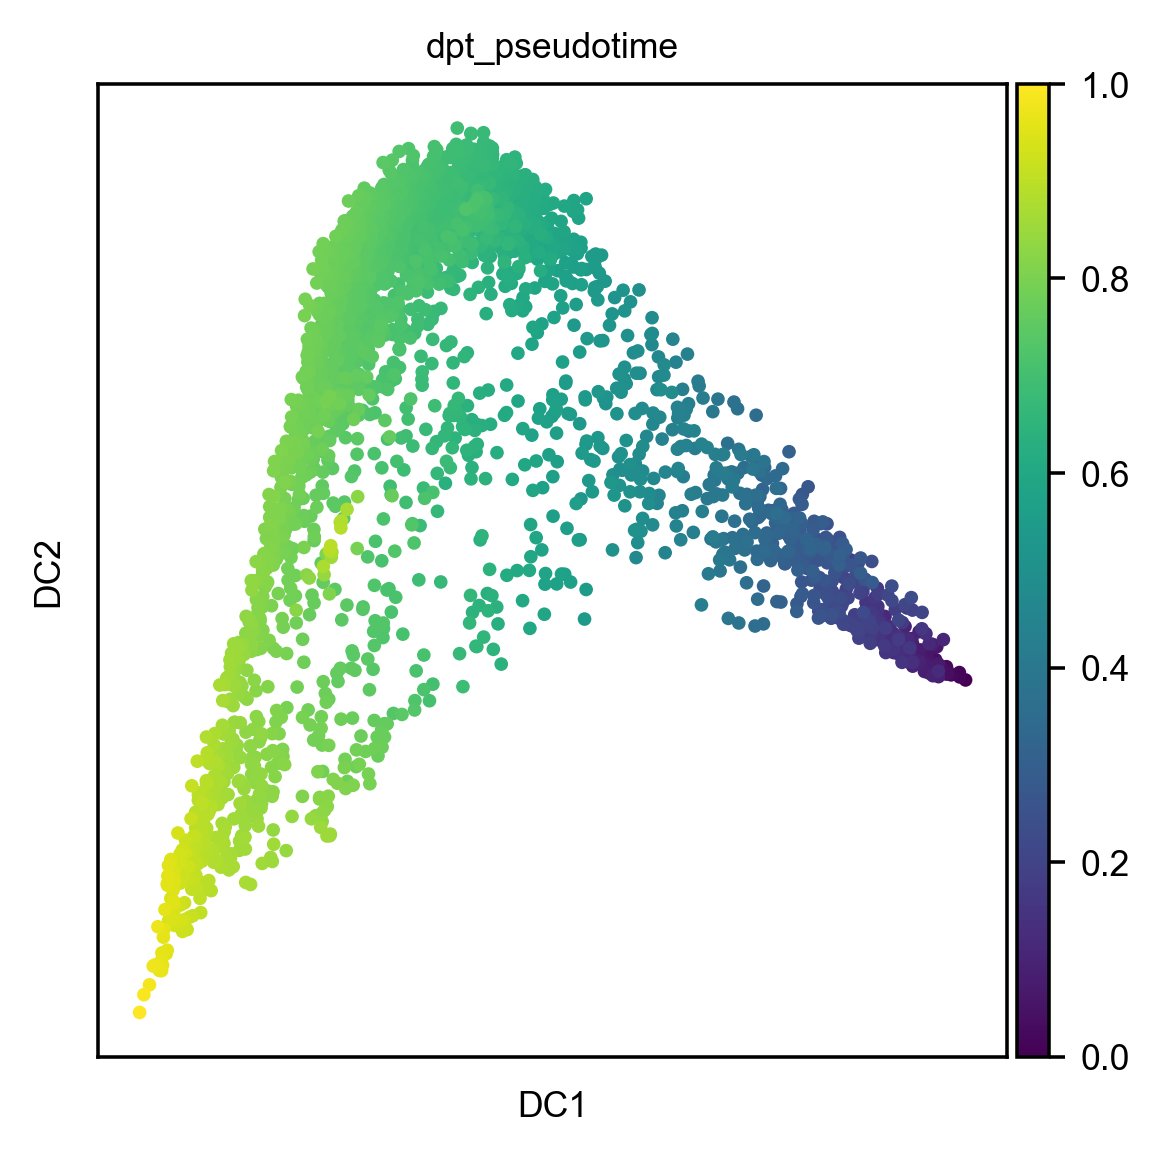

In [11]:
sc.pl.diffmap(adata, color="dpt_pseudotime")

## 04. run scVelo

In [12]:
ldata = scv.read(dir_for_scVelo_input_loom)
adata = scv.utils.merge(adata, ldata)
scv.pp.filter_and_normalize(adata, min_shared_cells=20, n_top_genes=200)

Filtered out 541 genes that are detected in less than 20 cells (shared).
Normalized count data: spliced, unspliced.
Extracted 200 highly variable genes.


In [13]:
scv.pp.moments(adata, n_pcs=20, n_neighbors=30)
scv.tl.recover_dynamics(adata, n_jobs=30)
scv.tl.velocity(adata, mode="dynamical", min_r2=None)
scv.tl.velocity_graph(adata, n_jobs=30, mode_neighbors="connectivities")

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 30/72 cores)
or disable the progress bar using `show_progress_bar=False`.


/raid1/cxy/tools/miniconda3/envs/py_3.8/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/raid1/cxy/tools/miniconda3/envs/py_3.8/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:24) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 30/72 cores)


/raid1/cxy/tools/miniconda3/envs/py_3.8/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_diffmap', embedded velocity vectors (adata.obsm)
saving figure to file 6H.RNA_velocity.pdf


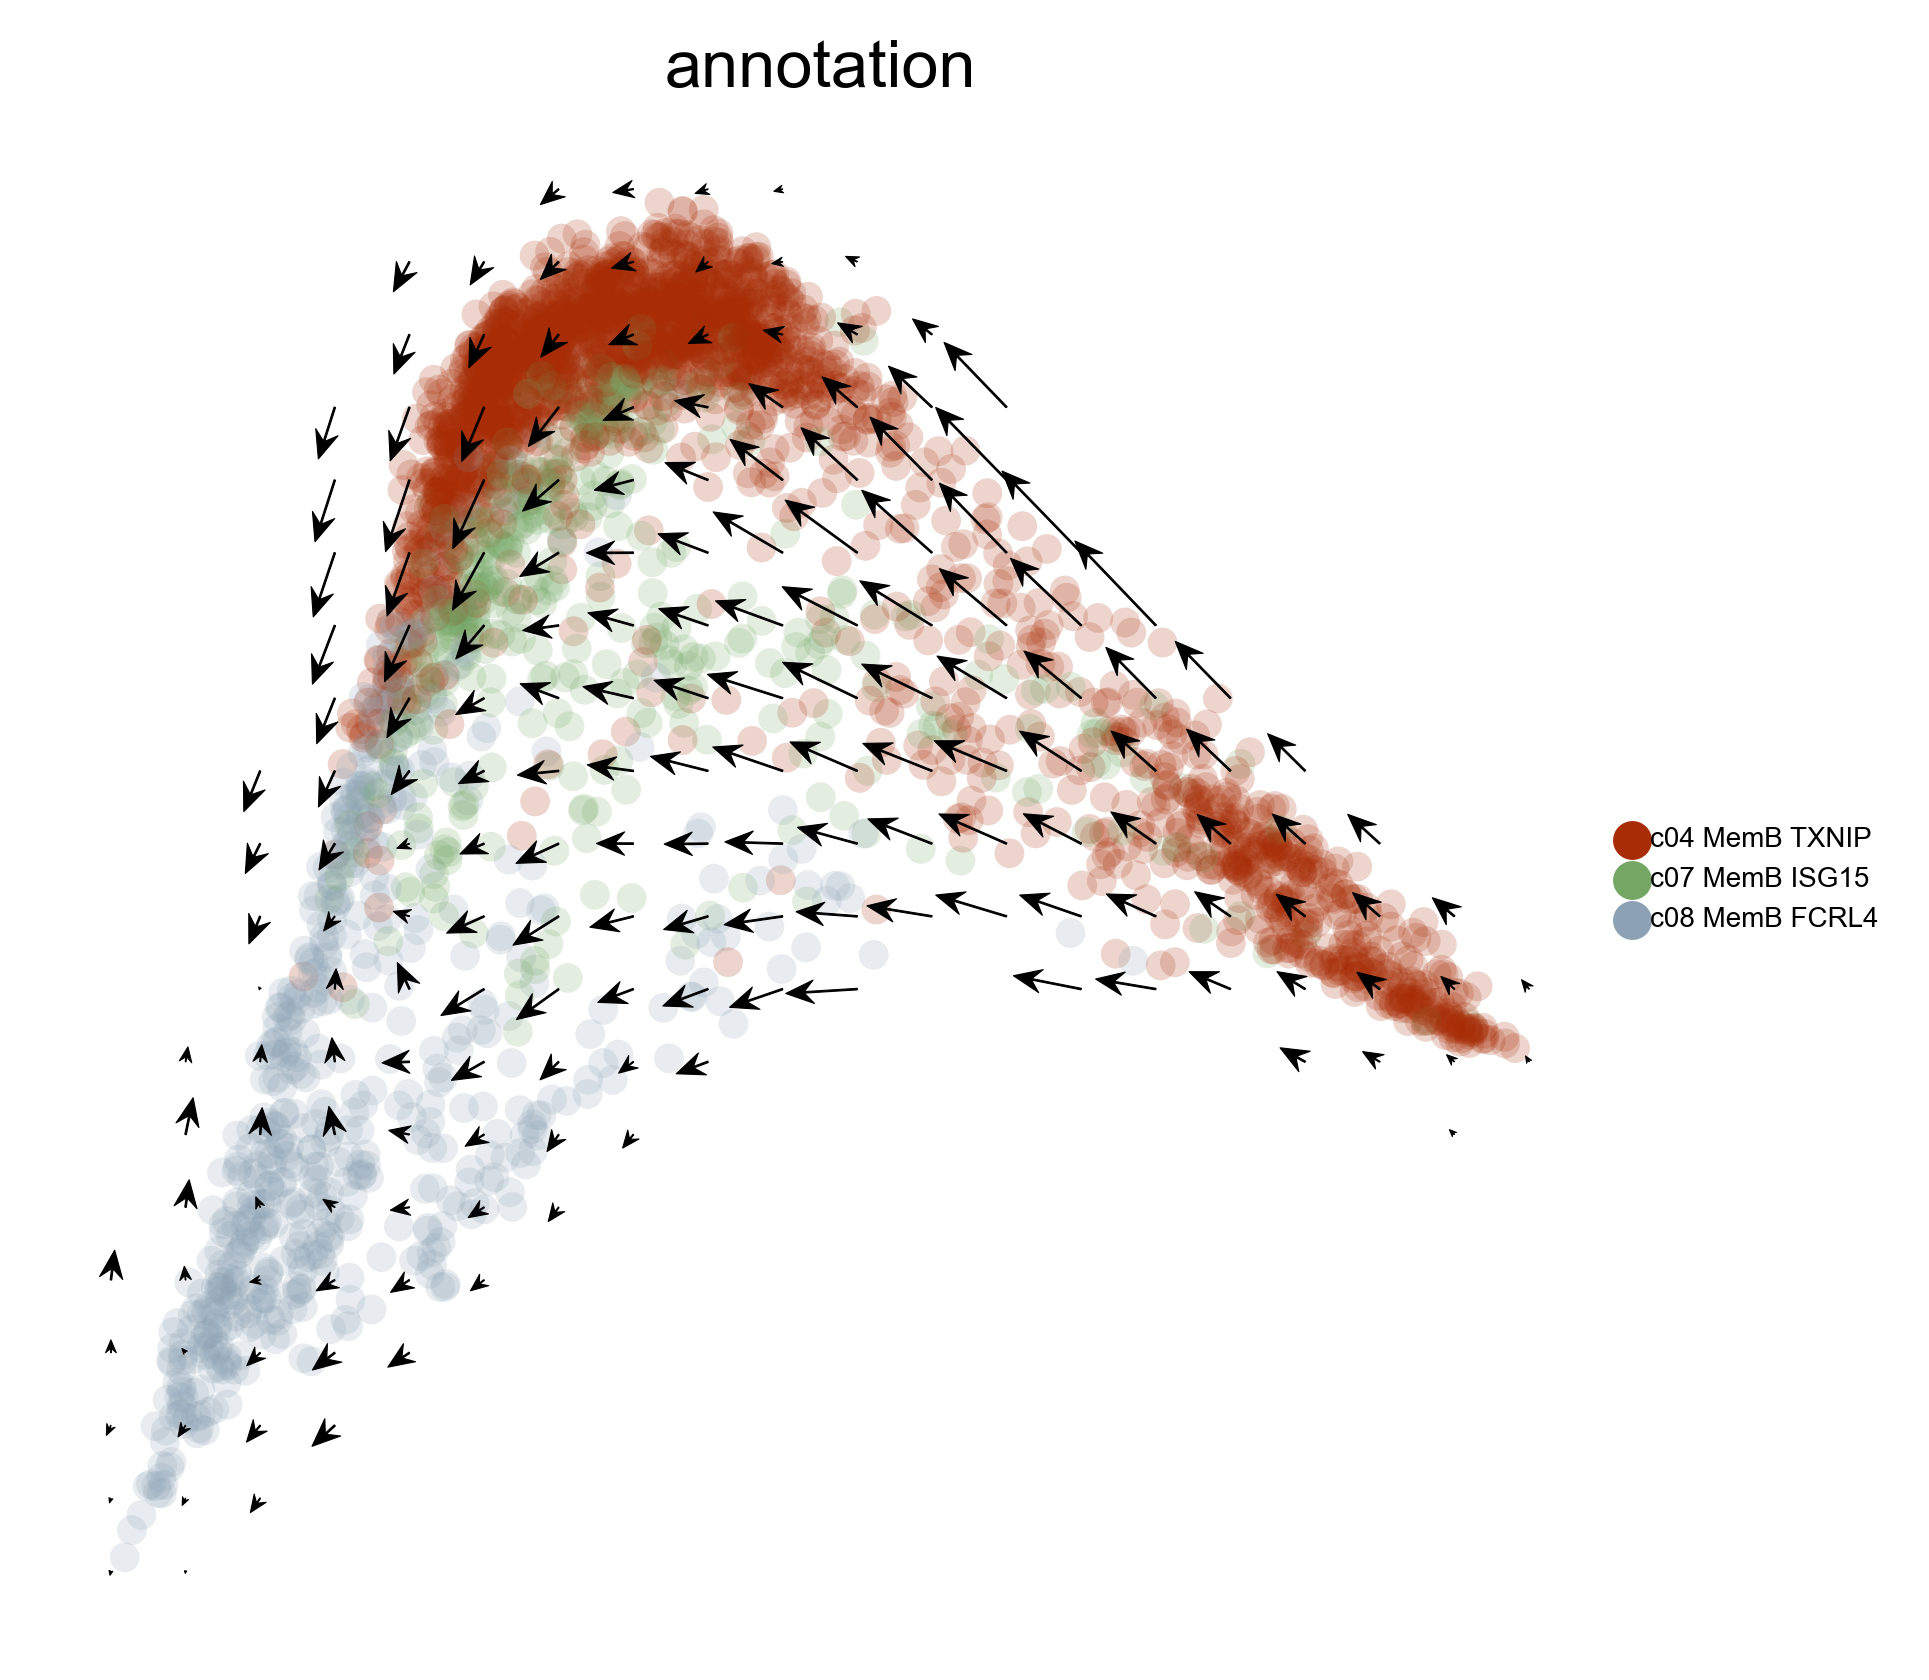

In [14]:
scv.settings.set_figure_params("scvelo", dpi=200)
scv.pl.velocity_embedding_grid(
    adata,
    basis="diffmap",
    color="annotation",
    arrow_size=3,
    arrow_length=3,
    density=0.4,
    arrow_color="black",
    legend_loc="right margin",
    legend_fontsize=5,
    save="6H.RNA_velocity.pdf",
    figsize=(5, 5)
)

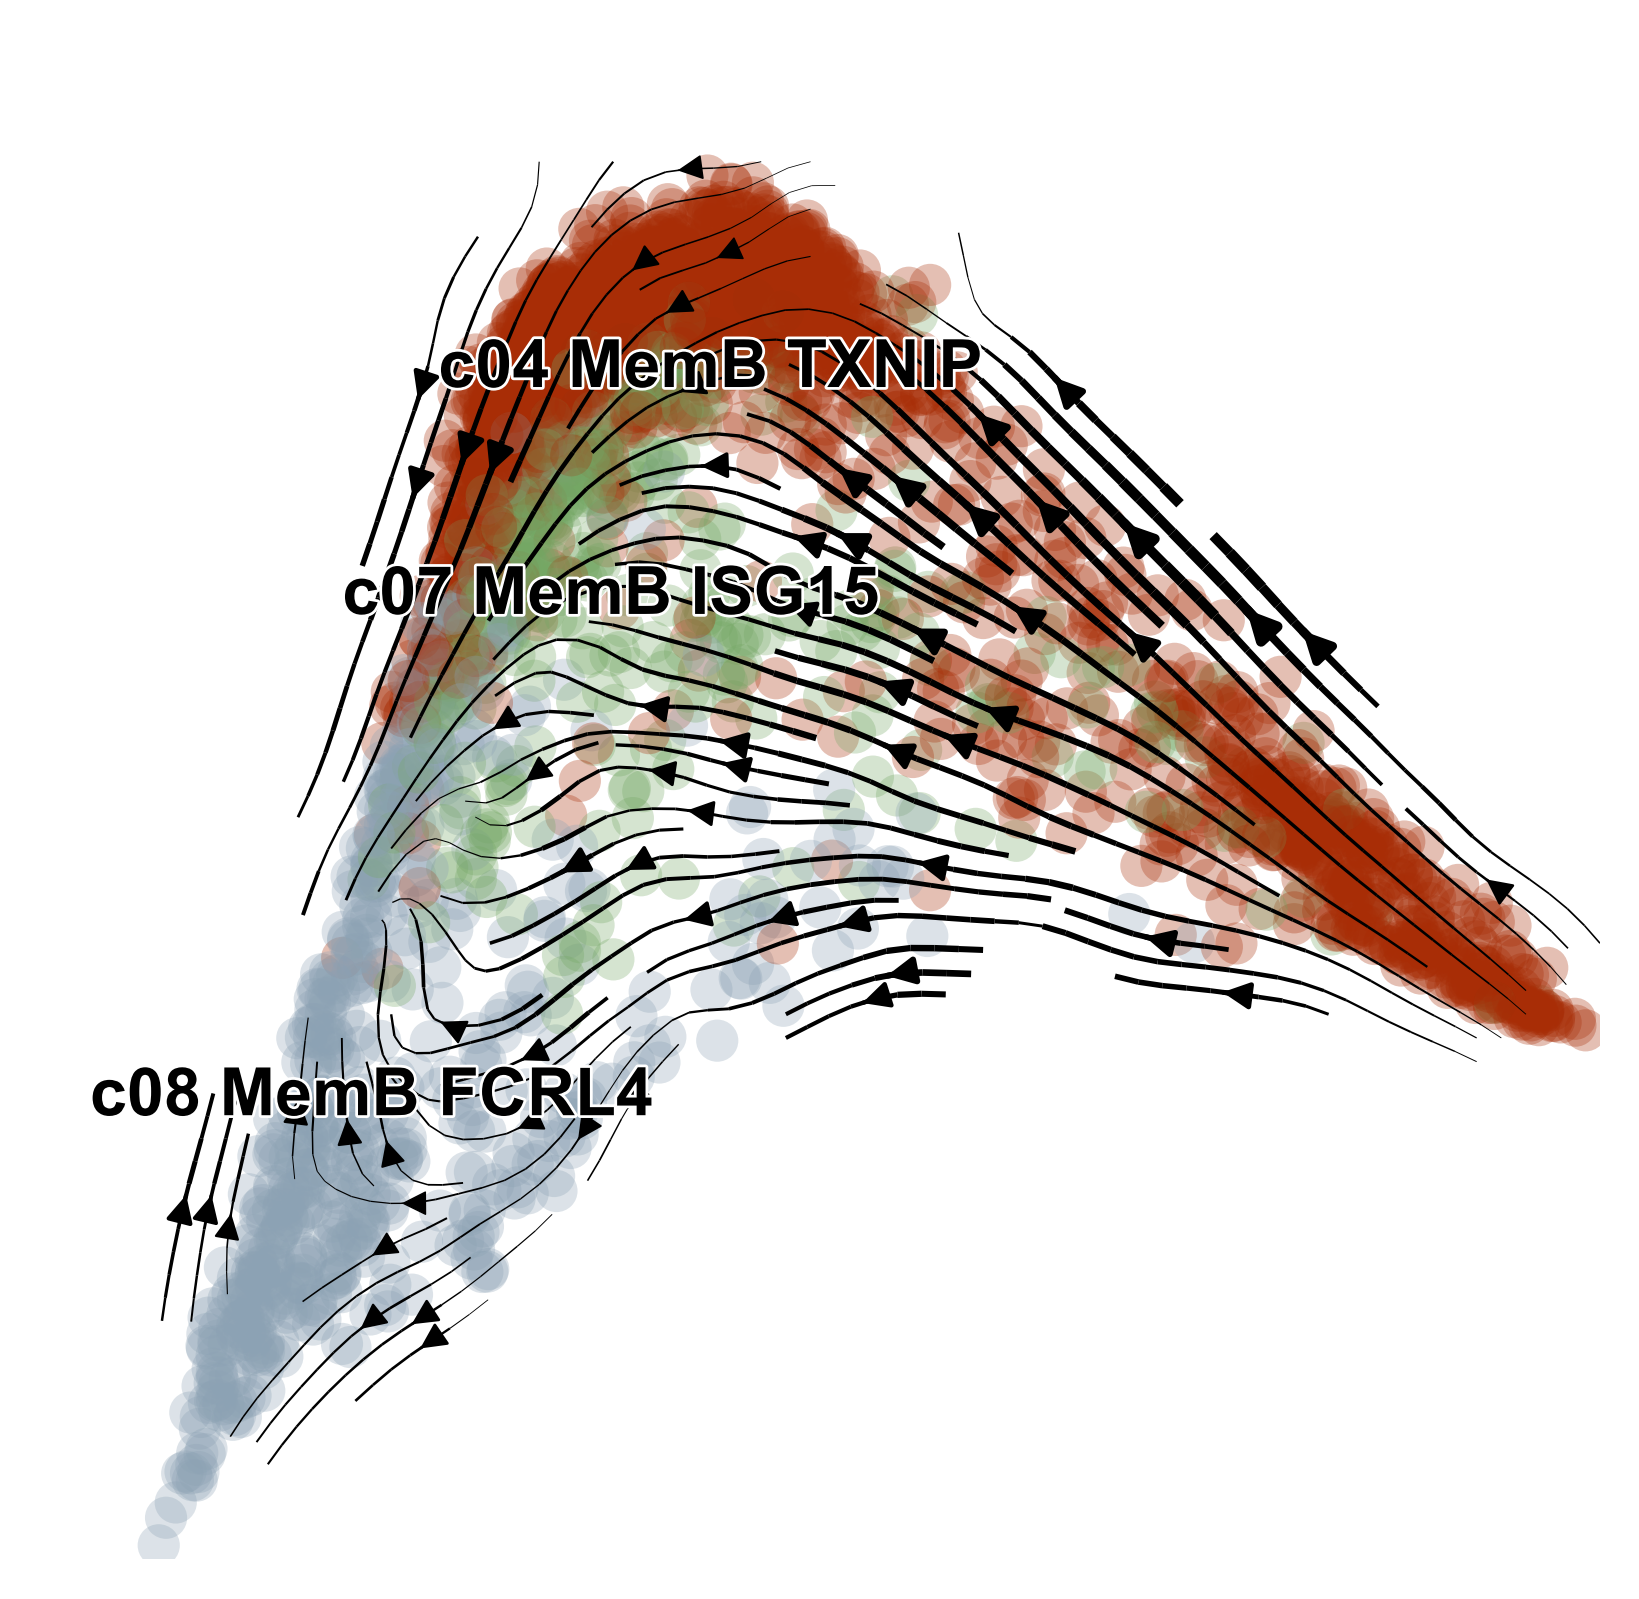

In [15]:
scv.pl.velocity_embedding_stream(
    adata,
    basis="diffmap",
    legend_fontsize=12,
    title="",
    smooth=0.8,
    min_mass=2.3,
    color="annotation",
    figsize=(5, 5)
)

## 05. CellRank

/tmp/ipykernel_52307/2561265767.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(
/raid1/cxy/tools/miniconda3/envs/py_3.8/lib/python3.8/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(
  0%|          | 0/3184 [00:00<?, ?cell/s]

100%|██████████| 3184/3184 [00:01<00:00, 2932.29cell/s]


saving figure to file S6C.CellRank_terminal.pdf


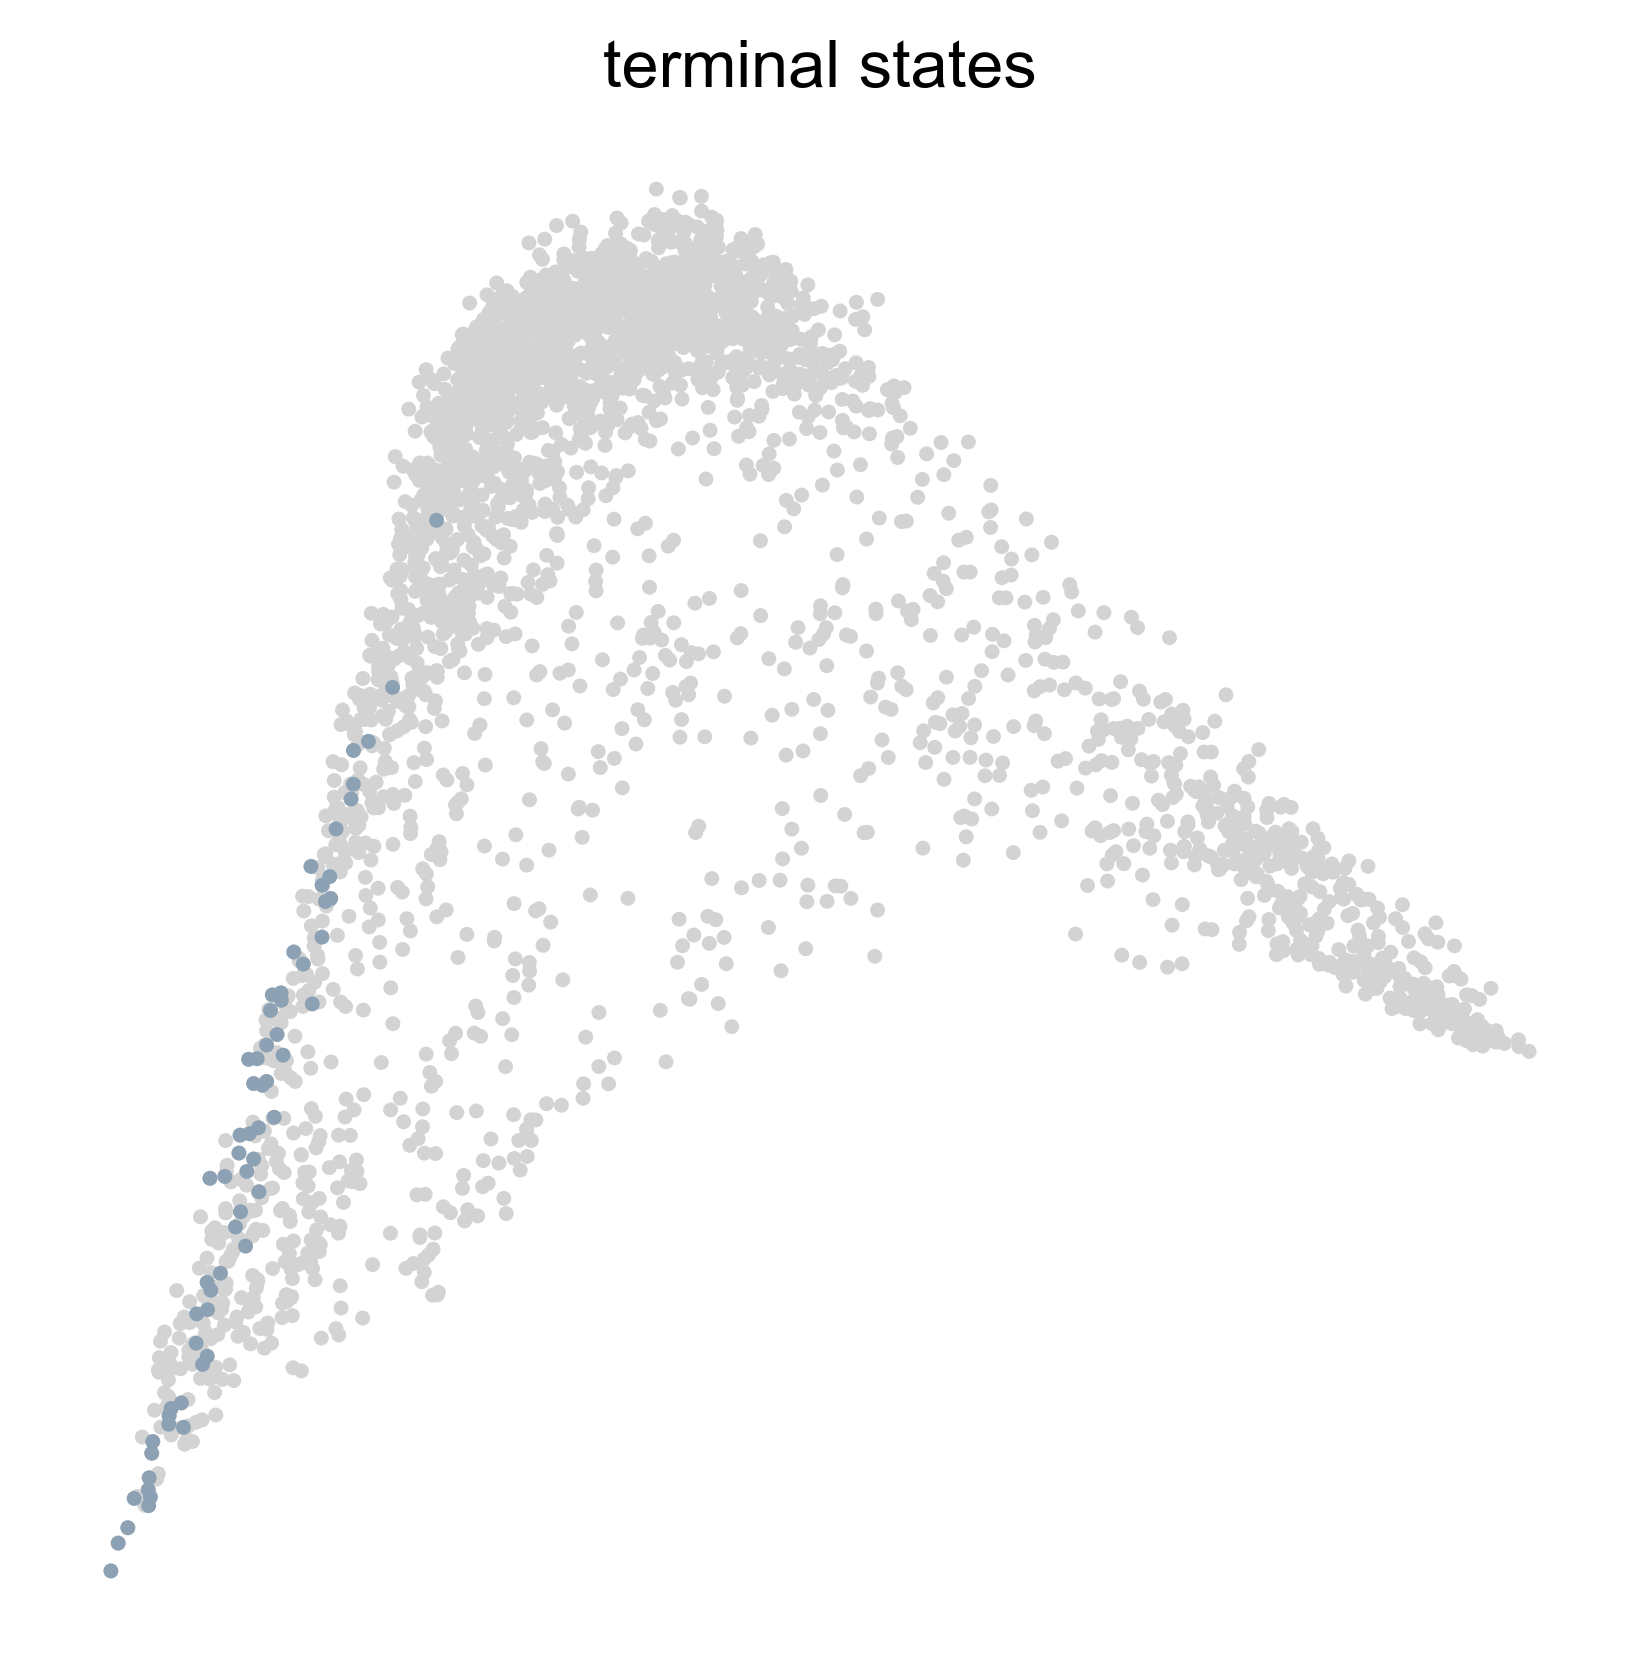

In [16]:
cr.tl.terminal_states(
    adata, cluster_key="annotation", estimator=cr.tl.estimators.CFLARE
)
cr.pl.terminal_states(
    adata,
    basis="diffmap",
    discrete=True,
    legend_loc='none', # remove label
    save="S6C.CellRank_terminal.pdf",
    figsize=(5, 5),
)

/tmp/ipykernel_52307/2138721498.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(adata, cluster_key="annotation", estimator=cr.tl.estimators.CFLARE)
/raid1/cxy/tools/miniconda3/envs/py_3.8/lib/python3.8/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(
100%|██████████| 3184/3184 [00:01<00:00, 2975.78cell/s]


saving figure to file S6C.CellRank_initial.pdf


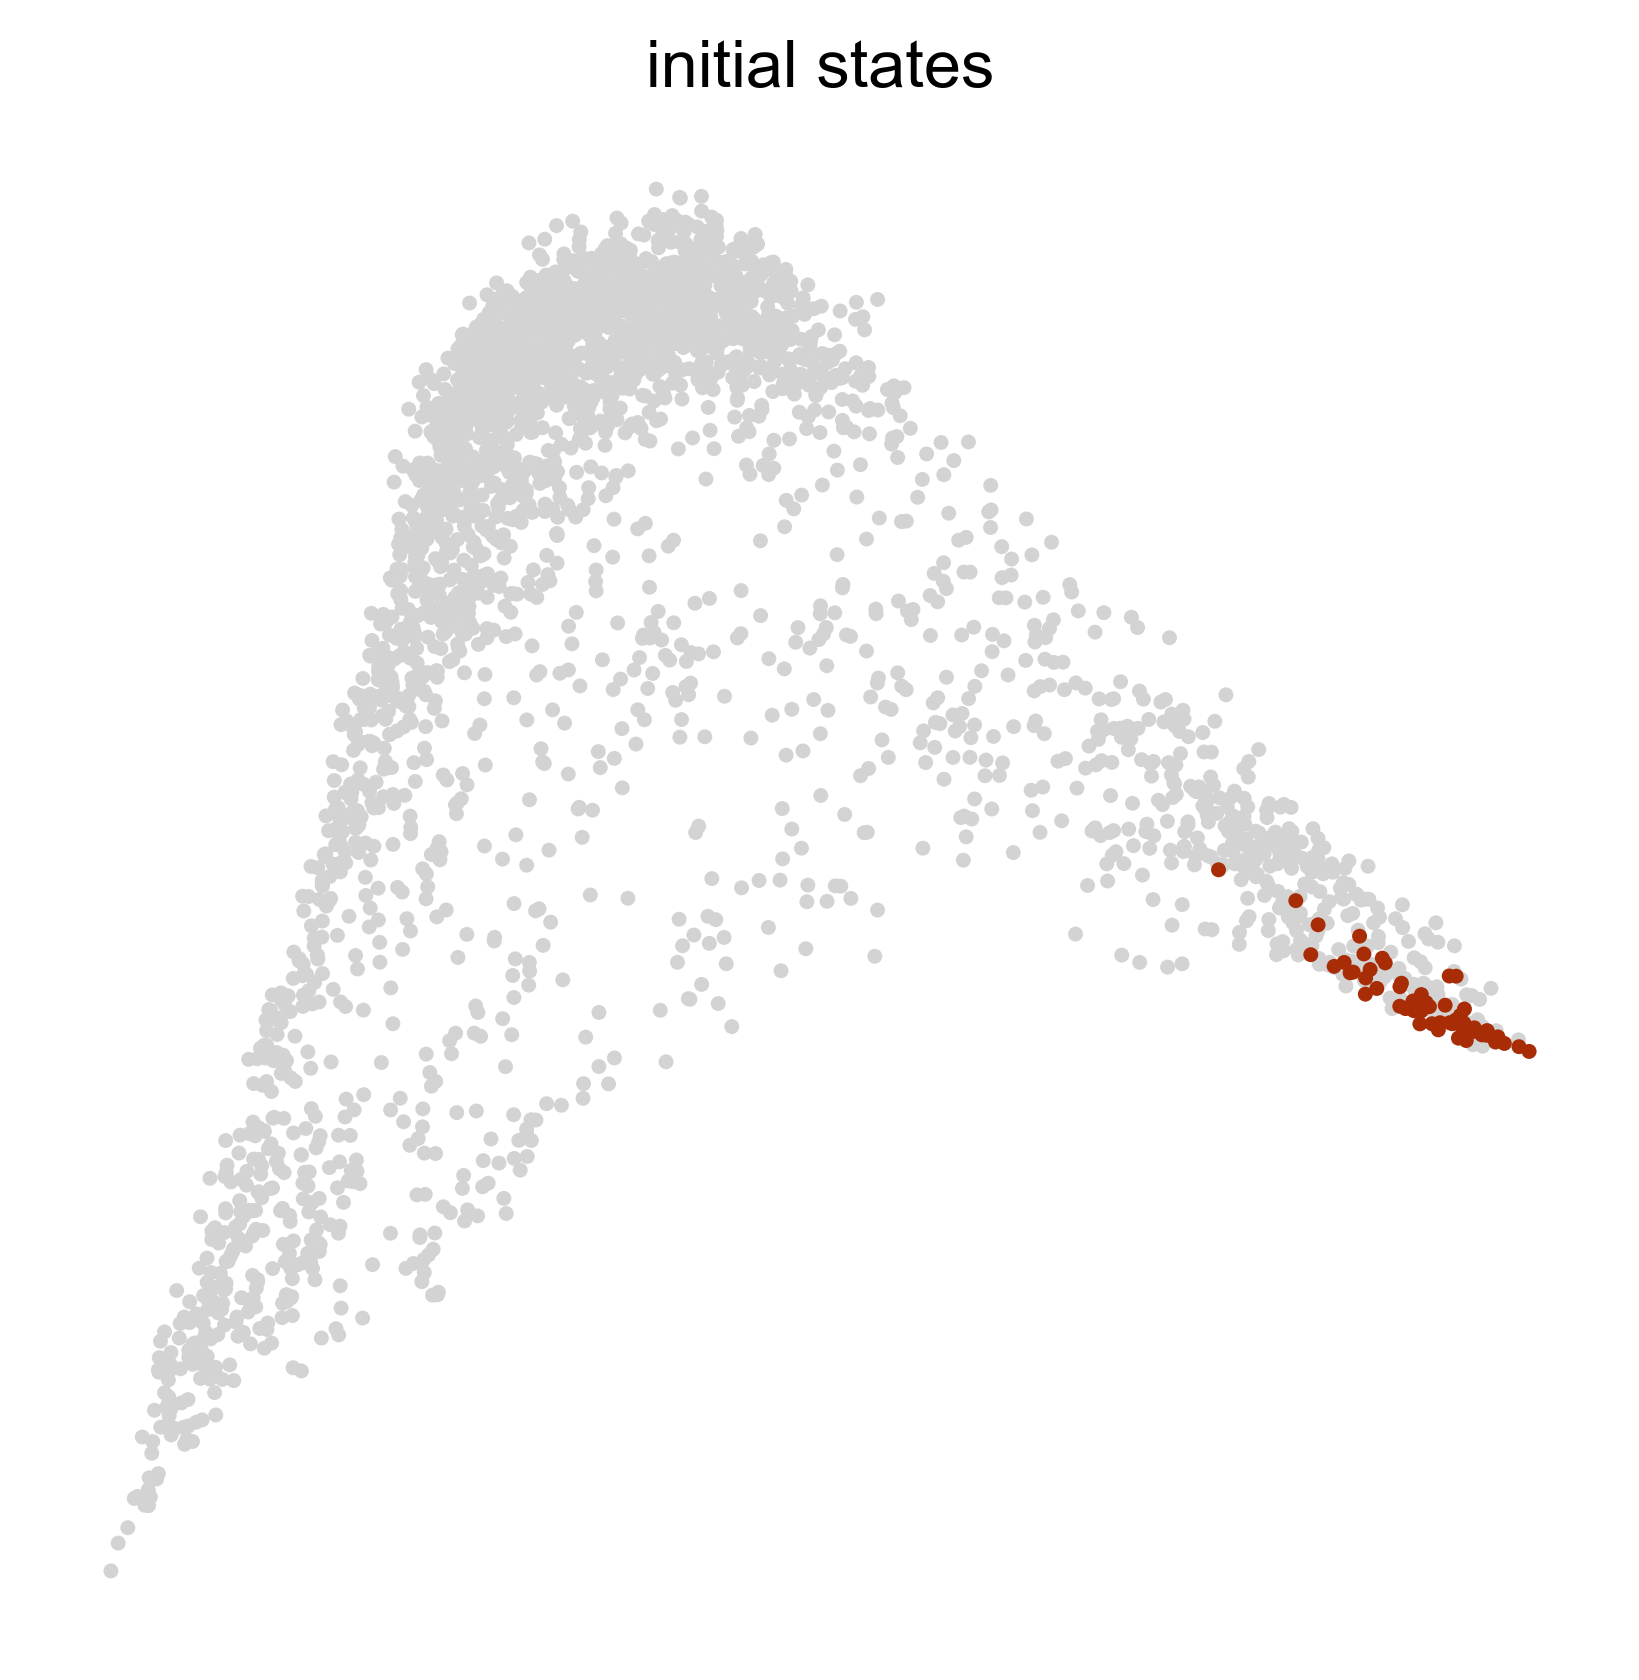

In [17]:
cr.tl.initial_states(adata, cluster_key="annotation", estimator=cr.tl.estimators.CFLARE)
cr.pl.initial_states(
    adata,
    basis="diffmap",
    discrete=True,
    legend_loc="none",  # remove label
    save="S6C.CellRank_initial.pdf",
    figsize=(5, 5),
)

## 06. pseudotime conversion to percentile rank values

In [18]:
adata.obs["dpt_order_perc"] = ss.rankdata(adata.obs["dpt_pseudotime"]) / len(
    adata.obs["dpt_pseudotime"]
)

saving figure to file S6D.diffusion_pseudotime.pdf


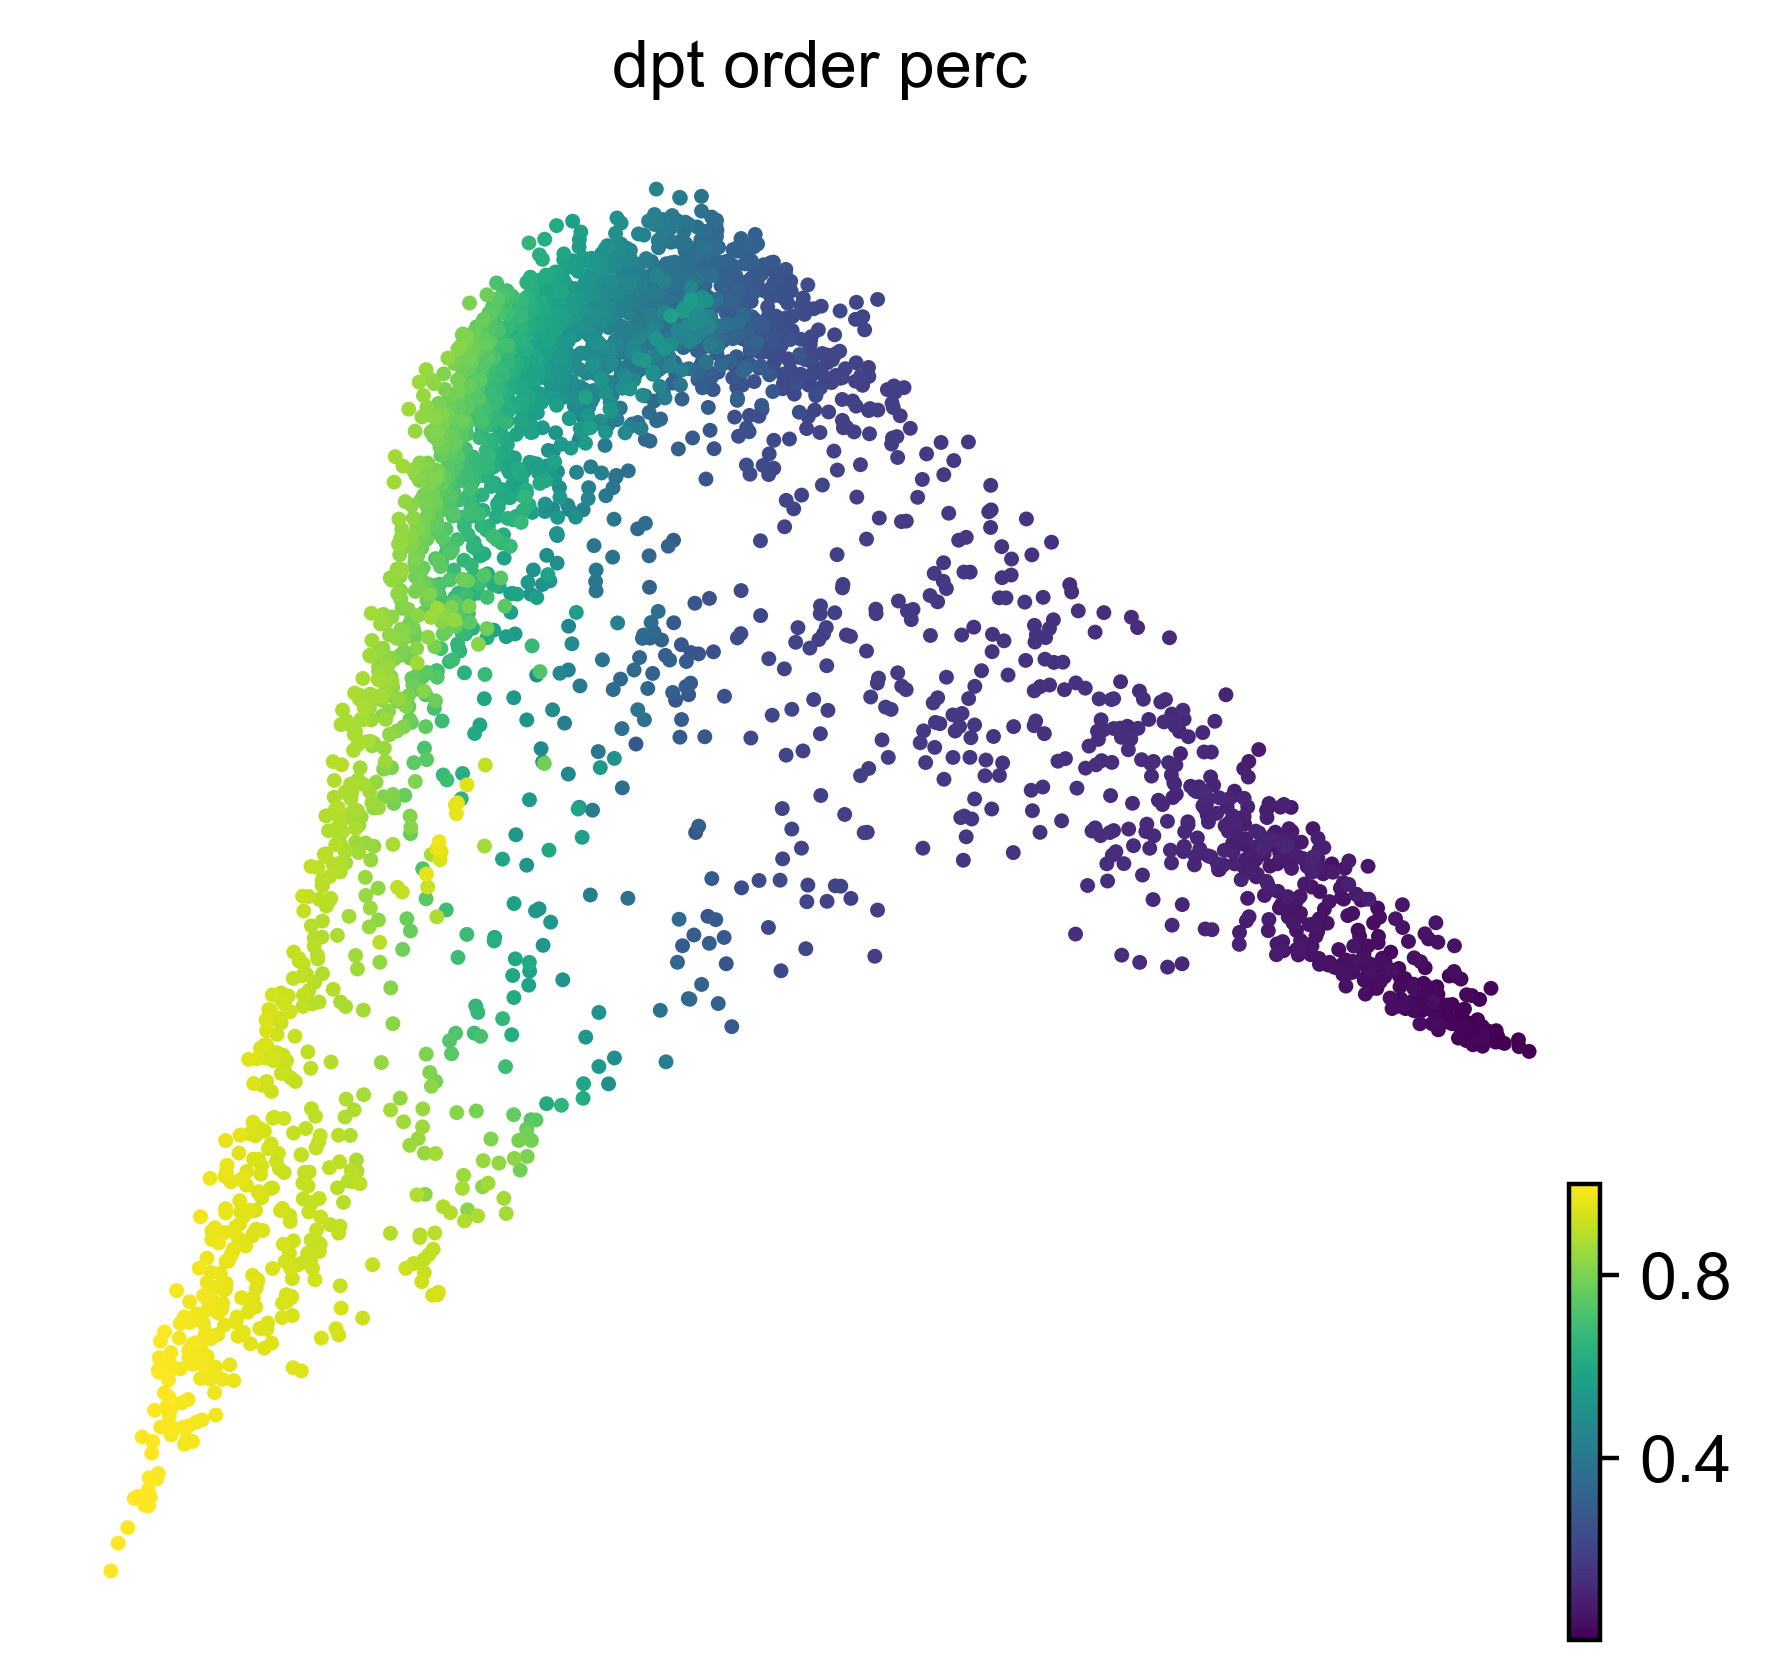

In [19]:
scv.pl.scatter(
    adata,
    basis="diffmap",
    color="dpt_order_perc",
    color_map="viridis",
    save="S6D.diffusion_pseudotime.pdf",
    figsize=(5, 5),
)

## 07. save

In [20]:
adata.obs["CellID_final"] = [
    f'{adata.obs["cellID"][i]}_{adata.obs["datasetID"][i]}_{adata.obs["sampleID"][i]}'
    for i in range(adata.obs.shape[0])
]
diff = pd.DataFrame(adata.obsm["X_diffmap"], index=adata.obs["CellID_final"])
diff.to_csv(f"{dir_for_data}/diffMap.txt", sep="\t")
adata.obs.loc[:, ["CellID_final", "annotation", "dpt_pseudotime"]].to_csv(
    f"{dir_for_data}/dpt_pseudotime.txt", sep="\t"
)